In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('./all/fer2013/fer2013.csv', dtype={'emotion':np.int32, 'pixels':str, 'Usage':str})

In [3]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df['pixels'] = df['pixels'].apply(lambda x: np.fromstring(x,sep=' '))

In [5]:
train = df.loc[df['Usage'] == 'Training']
validation = df.loc[df['Usage'] == 'PublicTest']
test = df.loc[df['Usage'] == 'PrivateTest']

In [6]:
y_train = pd.get_dummies(train['emotion'])
y_train.columns = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

In [7]:
y_validation = pd.get_dummies(validation['emotion'])
y_validation.columns = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

In [8]:
y_test = pd.get_dummies(test['emotion'])
y_test.columns = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

In [9]:
y_train.head()

,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1


In [10]:
x_train = np.vstack(train['pixels'].values)
x_validation = np.vstack(validation['pixels'].values)
x_test = np.vstack(test['pixels'].values)

In [11]:
x_train = np.reshape(x_train,(-1, 48, 48, 1))
x_validation = np.reshape(x_validation,(-1, 48, 48, 1))
x_test = np.reshape(x_test,(-1, 48, 48, 1))

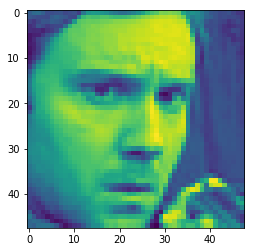

In [12]:
plt.imshow(x_train.squeeze()[0])

In [13]:
with tf.device('/cpu:0'):
    tf_x_train = tf.placeholder(tf.float32)
    tf_x_validation = tf.placeholder(tf.float32)
    tf_x_test = tf.placeholder(tf.float32)
    
    tf_x_train_norm = tf.image.per_image_standardization(tf_x_train)
    tf_x_validation_norm = tf.image.per_image_standardization(tf_x_validation)
    tf_x_test_norm = tf.image.per_image_standardization(tf_x_test)

In [14]:
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    x_train_norm,x_validation_norm,x_test_norm = sess.run([tf_x_train_norm,tf_x_validation_norm,tf_x_test_norm], feed_dict={tf_x_train: x_train,
                                                   tf_x_validation: x_validation,
                                                   tf_x_test: x_test
                                                  })

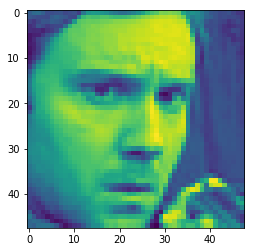

In [15]:
plt.imshow(x_train_norm.squeeze()[0])

In [16]:
x_train_norm[0].max()

1.2543709

In [17]:
x_train_norm[0].min()

-1.838045

In [18]:
training_iters = 200 
learning_rate = 0.01
batch_size = 512

In [19]:
n_classes = 7

In [20]:
x = tf.placeholder("float", [None, 48,48,1])
y = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

In [21]:
weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W3', shape=(6*6*128,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W6', shape=(128,n_classes), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(n_classes), initializer=tf.contrib.layers.xavier_initializer()),
}

In [22]:
def conv_net(x, weights, biases):  

    # here we call the conv2d function we had defined above and pass the input image x, weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 14*14 matrix.
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    # here we call the conv2d function we had defined above and pass the input image x, weights wc2 and bias bc2.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 7*7 matrix.
    conv2 = maxpool2d(conv2, k=2)

    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 4*4.
    conv3 = maxpool2d(conv3, k=2)


    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    drop_out = tf.nn.dropout(fc1, keep_prob)  # DROP-OUT
    fc1 = tf.nn.relu(drop_out)
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term. 
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [23]:
pred = conv_net(x, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [24]:
#Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image. and both will be a column vector.
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

#calculate accuracy across all the given images and average them out. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [25]:
# Initializing the variables
init = tf.global_variables_initializer()

In [26]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    
    for i in range(training_iters):
        for batch in range(len(x_train_norm)//batch_size):
            batch_x = x_train_norm[batch*batch_size:min((batch+1)*batch_size,len(x_train_norm))]
            batch_y = y_train[batch*batch_size:min((batch+1)*batch_size,len(y_train))]    
            
            opt = sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5})
            
        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))

        test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: x_validation_norm, y : y_validation,  keep_prob : 1})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Validation Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()

Iter 0, Loss= 1.826584, Training Accuracy= 0.21484
Validation Accuracy: 0.24909
Iter 1, Loss= 1.805211, Training Accuracy= 0.22852
Validation Accuracy: 0.32460
Iter 2, Loss= 1.747358, Training Accuracy= 0.29688
Validation Accuracy: 0.33853
Iter 3, Loss= 1.712831, Training Accuracy= 0.32812
Validation Accuracy: 0.35414
Iter 4, Loss= 1.706079, Training Accuracy= 0.32617
Validation Accuracy: 0.37030
Iter 5, Loss= 1.659495, Training Accuracy= 0.35742
Validation Accuracy: 0.38089
Iter 6, Loss= 1.656624, Training Accuracy= 0.33594
Validation Accuracy: 0.38479
Iter 7, Loss= 1.679431, Training Accuracy= 0.36328
Validation Accuracy: 0.39147
Iter 8, Loss= 1.639543, Training Accuracy= 0.36133
Validation Accuracy: 0.39537
Iter 9, Loss= 1.616918, Training Accuracy= 0.36914
Validation Accuracy: 0.40234
Iter 10, Loss= 1.638970, Training Accuracy= 0.36133
Validation Accuracy: 0.40596
Iter 11, Loss= 1.592363, Training Accuracy= 0.38281
Validation Accuracy: 0.40903
Iter 12, Loss= 1.563010, Training Accu

Iter 102, Loss= 1.383476, Training Accuracy= 0.45312
Validation Accuracy: 0.45723
Iter 103, Loss= 1.348577, Training Accuracy= 0.46094
Validation Accuracy: 0.45138
Iter 104, Loss= 1.379518, Training Accuracy= 0.45508
Validation Accuracy: 0.44915
Iter 105, Loss= 1.381584, Training Accuracy= 0.45898
Validation Accuracy: 0.43801
Iter 106, Loss= 1.386754, Training Accuracy= 0.43359
Validation Accuracy: 0.44191
Iter 107, Loss= 1.367650, Training Accuracy= 0.44531
Validation Accuracy: 0.44246
Iter 108, Loss= 1.372880, Training Accuracy= 0.44336
Validation Accuracy: 0.44413
Iter 109, Loss= 1.343125, Training Accuracy= 0.46094
Validation Accuracy: 0.45556
Iter 110, Loss= 1.413282, Training Accuracy= 0.42969
Validation Accuracy: 0.44887
Iter 111, Loss= 1.353521, Training Accuracy= 0.44727
Validation Accuracy: 0.44441
Iter 112, Loss= 1.365983, Training Accuracy= 0.46094
Validation Accuracy: 0.44107
Iter 113, Loss= 1.369354, Training Accuracy= 0.45312
Validation Accuracy: 0.45862
Iter 114, Loss= 

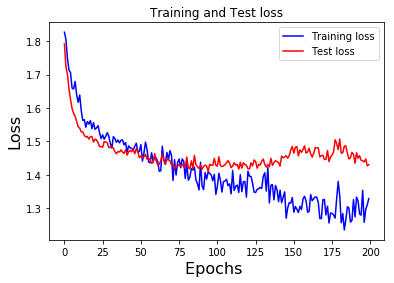

<Figure size 432x288 with 0 Axes>

In [27]:
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

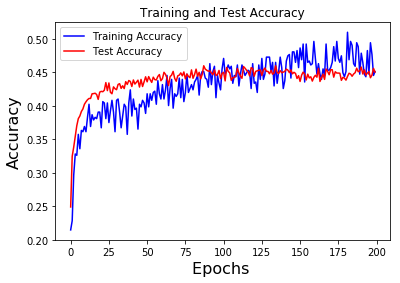

<Figure size 432x288 with 0 Axes>

In [28]:
plt.plot(range(len(train_accuracy)), train_accuracy, 'b', label='Training Accuracy')
plt.plot(range(len(test_accuracy)), test_accuracy, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.legend()
plt.figure()
plt.show()